In [2]:
cd ..

/Users/hyunminhong/Kalman-Heston-Filter


In [3]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from scipy.stats import norm, lognorm, ncx2
import statsmodels.api as sm

from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

from src.Utility import Utility, MeasurementType
# from src.KalmanFilterCorrFTE import HestonKalmanFilterFTE
from src.KalmanFilterCorr_copy import HestonKalmanFilterCorr
from src.ParticleFilter import PFHeston
from src.RealizedGARCH import RealizedGARCH
from src.Heston import *
from scipy.optimize import minimize
from arch import arch_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

current_dir = Path().resolve()
parent_dir = current_dir.parent
sys.path.insert(0, str(parent_dir))

In [4]:
df = pd.read_parquet(r"data/oxford_data.parquet")

df = df.rename(columns={'Unnamed: 0': 'Time'})
df = df.loc[df['Symbol']=='.SPX'].reset_index(drop=True)
df['Time'] = pd.to_datetime(df['Time'], utc=True) 
df['Time'] = df['Time'].dt.date
df = df.set_index('Time')
df.index = pd.to_datetime(df.index)
df = df.loc[pd.to_datetime('2014-01-01'):pd.to_datetime('2018-06-01')]
df['return'] = np.log(df['close_price']).diff()

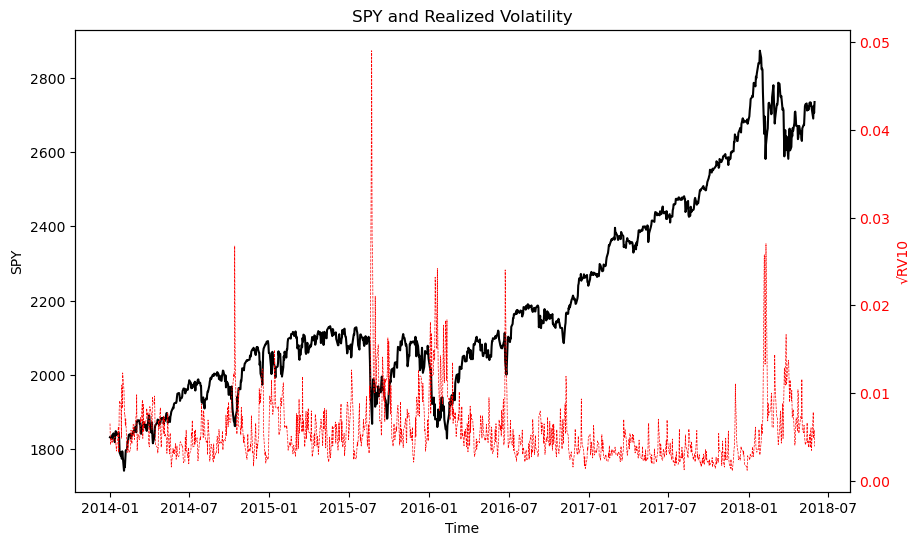

In [4]:
# Assuming df is your DataFrame and already has datetime index
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot close price on the left y-axis
color = 'black'
ax1.set_xlabel('Time')
ax1.set_ylabel('SPY', color=color)
ax1.plot(df.index, df['close_price'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create second y-axis for RV
ax2 = ax1.twinx()
color = 'red'
ax2.set_ylabel('√RV10', color=color)
ax2.plot(df.index, np.sqrt(df['rv10']), color=color, linestyle='dashed', linewidth=0.5)
ax2.tick_params(axis='y', labelcolor=color)

# Show plot
plt.title('SPY and Realized Volatility')
plt.show()

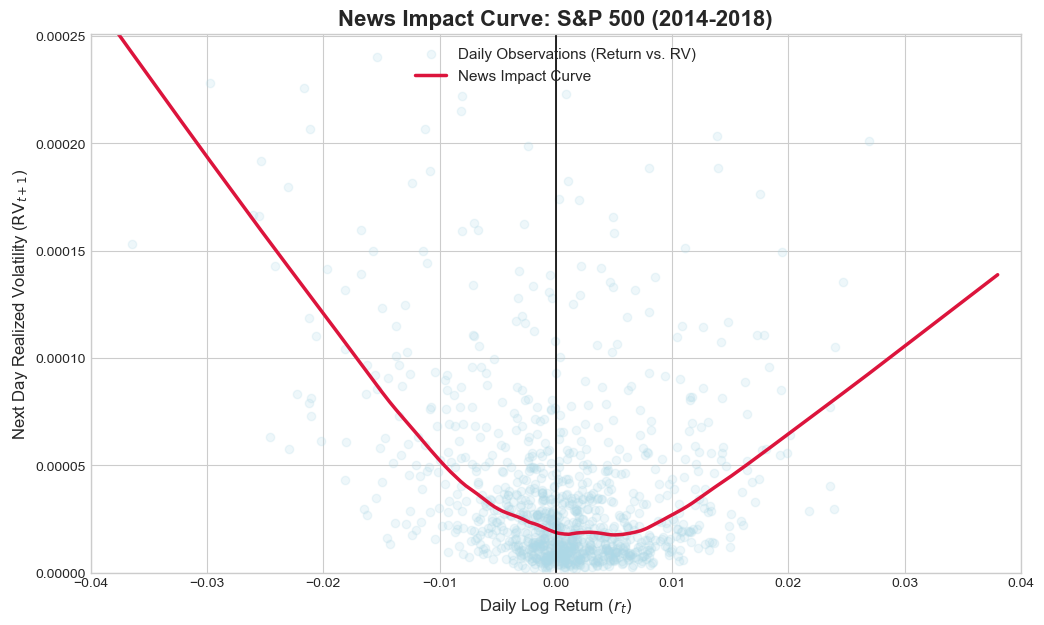

In [5]:
df['next_day_rv10'] = df['rv10'].shift(-1)

df_nic = df.dropna()

# Define our x (independent) and y (dependent) variables
x_returns = df_nic['return']
y_next_vol = df_nic['next_day_rv10']

# --- 3. Perform LOWESS Smoothing ---
# LOWESS fits a smooth curve to the data non-parametrically.
# The 'frac' parameter controls the amount of smoothing (0.3 is a good start).
lowess_fit = sm.nonparametric.lowess(endog=y_next_vol, exog=x_returns, frac=0.3)

# Extract the smoothed x and y values
x_smooth = lowess_fit[:, 0]
y_smooth = lowess_fit[:, 1]

# --- 4. Generate the Plot ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 7))

# Plot the raw observations as a scatter plot
ax.scatter(x_returns, y_next_vol, alpha=0.2, color='lightblue', label='Daily Observations (Return vs. RV)')

# Plot the smoothed News Impact Curve
ax.plot(x_smooth, y_smooth, color='crimson', linewidth=2.5, label='News Impact Curve')

# Add reference lines for clarity
# ax.axhline(y=y_next_vol.mean(), color='dimgray', linestyle='--', linewidth=1.5, label=f'Unconditional Mean RV')
ax.axvline(x=0, color='black', linestyle='-', linewidth=1.2)

# Add titles and labels for a publication-quality figure
ax.set_title('News Impact Curve: S&P 500 (2014-2018)', fontsize=16, weight='bold')
ax.set_xlabel('Daily Log Return ($r_t$)', fontsize=12)
ax.set_ylabel('Next Day Realized Volatility ($\mathrm{RV}_{t+1}$)', fontsize=12)
ax.legend(loc='upper center', fontsize=11)

# Set axis limits to focus on the area of interest
ax.set_xlim(-0.04, 0.04)
ax.set_ylim(0, df_nic['next_day_rv10'].quantile(0.98)) # Zoom in by excluding extreme outliers

plt.show()


In [6]:
daily_returns = df['return'].iloc[1:]
daily_RV = df['rv10'].iloc[1:]

burnin = 252
dt = 1  # Daily

split_index = round(df.shape[0] * 0.82)

# TRAINING SET 
train_returns = daily_returns[:split_index]
train_RV = daily_RV[:split_index]

# TEST SET 
test_returns = daily_returns[split_index:]
test_RV = daily_RV[split_index:]

## RV-QLKF

In [7]:
hkf_both_corr = HestonKalmanFilterCorr(measurement_type=MeasurementType.BOTH, dt=dt, V0=daily_RV[0], P0=0.1)
hkf_both_corr.set_data(returns=train_returns, rv=train_RV)
initial_params_both_corr = np.array([0.01, 0.002, 0.001, 0.001, 0.001, -0.25]) # kappa, theta, xi, mu, sigma, rho
# 0.0194974349, 0.00108918014, 0.00817043974, 0.0000760274950, 0.00000100000000, -0.499673084
fit_results_both_corr = hkf_both_corr.fit(initial_params=initial_params_both_corr, burnin=burnin)
params_opt_both_corr = fit_results_both_corr['params']
print("Optimized parameters (BOTH):", params_opt_both_corr)

train_result_both_corr = hkf_both_corr.filter(params_opt_both_corr)
last_V_train_corr = train_result_both_corr['V_filt'][-1]
last_P_train_corr = train_result_both_corr['P_filt'][-1]

hkf_both_test_corr = HestonKalmanFilterCorr(measurement_type=MeasurementType.BOTH, dt=dt, V0=last_V_train_corr, P0=last_P_train_corr)
test_result_both_corr = hkf_both_test_corr.filter(params=params_opt_both_corr, returns=test_returns, rv=test_RV)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.53317D+03    |proj g|=  1.16871D+06

At iterate    1    f= -6.99021D+03    |proj g|=  9.14446D+04

At iterate    2    f= -7.02482D+03    |proj g|=  4.35286D+03

At iterate    3    f= -7.03530D+03    |proj g|=  6.62032D+03

At iterate    4    f= -7.05796D+03    |proj g|=  3.09380D+04

At iterate    5    f= -7.15105D+03    |proj g|=  1.23990D+00

At iterate    6    f= -7.27169D+03    |proj g|=  7.40393D-01

At iterate    7    f= -7.38099D+03    |proj g|=  7.40319D-01

At iterate    8    f= -7.40026D+03    |proj g|=  6.73981D+03

At iterate    9    f= -7.47302D+03    |proj g|=  3.17797D+03

At iterate   10    f= -7.47599D+03    |proj g|=  3.73659D+04

At iterate   11    f= -7.48430D+03    |proj g|=  4.44629D+05

At iterate   12    f= -7.50183D+03    |proj g|=  7.40518D-01

At iterate   13    f= -7.5


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


## QLKF

In [8]:
# Fit the model using training data
hkf_returns_corr = HestonKalmanFilterCorr(measurement_type=MeasurementType.RETURNS, dt=dt, V0=daily_RV[0], P0=0.1)
hkf_returns_corr.set_data(returns=train_returns)
initial_params_returns_corr = np.array([0.02, 0.00015, 0.00138, 0.0002, -0.25]) # kappa, theta, xi, mu, rho
# initial_params_returns_corr = np.array([0.02, 0.002, 0.001, 0.001, -0.5]) # kappa, theta, xi, mu, sigma, rho

fit_results_returns_corr = hkf_returns_corr.fit(initial_params=initial_params_returns_corr, burnin=burnin)
params_opt_returns_corr = fit_results_returns_corr['params']
print("Optimized parameters (RETURNS):", params_opt_returns_corr)

train_result_returns_corr = hkf_returns_corr.filter(params_opt_returns_corr)
last_V_returns_corr = train_result_returns_corr['V_filt'][-1]
last_P_returns_corr = train_result_returns_corr['P_filt'][-1]

hkf_returns_test_corr = HestonKalmanFilterCorr(measurement_type=MeasurementType.RETURNS, dt=dt, V0=last_V_returns_corr, P0=last_P_returns_corr)
test_result_returns_corr = hkf_returns_test_corr.filter(params=params_opt_returns_corr, returns=test_returns)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.16538D+03    |proj g|=  8.77265D+03

At iterate    1    f= -2.20939D+03    |proj g|=  7.10797D+03

At iterate    2    f= -2.21526D+03    |proj g|=  5.13867D+03

At iterate    3    f= -2.25500D+03    |proj g|=  6.67456D+03

At iterate    4    f= -2.32076D+03    |proj g|=  1.77356D+03

At iterate    5    f= -2.32547D+03    |proj g|=  1.63738D+04

At iterate    6    f= -2.32811D+03    |proj g|=  1.43140D+04

At iterate    7    f= -2.33100D+03    |proj g|=  3.95271D+05

At iterate    8    f= -2.33178D+03    |proj g|=  1.63152D+04

At iterate    9    f= -2.33178D+03    |proj g|=  4.51090D+02

At iterate   10    f= -2.33178D+03    |proj g|=  3.13478D+02

At iterate   11    f= -2.33180D+03    |proj g|=  3.05101D+04

At iterate   12    f= -2.33181D+03    |proj g|=  4.28813D+04

At iterate   13    f= -2.3


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


## PF 

In [9]:
pf_heston_train = PFHeston(train_returns, N=5000, dt=1/252, is_log=True)

param_bounds_train = [
    (0.02, 0.5),      # mu
    (1, 9),           # kappa
    (0.02, 0.2),     # theta
    (0.01, 0.91),       # xi
    (-0.5, 0),        # rho
    daily_RV[0]       # v0
]

_, estimated_param = pf_heston_train.filter(param_bounds_train, predict_obs=False)
param_bounds = list(zip(estimated_param[:,-1] - 1e-3, estimated_param[:,-1] + 1e-3))

resampling since: 1.109320379486056
resampling since: 210.02780615672734
resampling since: 3230.9944601352704
resampling since: 2788.8735026217437
resampling since: 2111.8407894402126
resampling since: 3386.691279192059
resampling since: 3330.6516229246936
resampling since: 3255.2793021169023
resampling since: 3357.8752217335723
resampling since: 3485.50438614718
resampling since: 3067.6307276877506
resampling since: 2453.08831863338
resampling since: 3237.6233295899283
resampling since: 3410.429068174833
resampling since: 3260.221881135075
resampling since: 3465.9269457523856
resampling since: 2151.698238942448
resampling since: 3082.1595361647815
resampling since: 1723.604588661759
resampling since: 2726.4209365396823
resampling since: 3488.705030413319
resampling since: 3224.18268467466
resampling since: 3432.6807592845653
resampling since: 3066.982807423503
resampling since: 3105.508275760852
resampling since: 3262.7341917537465
resampling since: 3042.148263804516
resampling since:

In [10]:
pf_heston_test = PFHeston(test_returns, N=5000, dt=1/252, is_log=True)

V_pf_train, _ = pf_heston_train.filter([*param_bounds, daily_RV[0]], predict_obs=False)
V_pf_test, _ = pf_heston_test.filter([*param_bounds, V_pf_train[-1]], predict_obs=False)

resampling since: 2230.709194638278
resampling since: 3132.826046542687
resampling since: 3386.274083795904
resampling since: 2746.2731937991534
resampling since: 3476.117818863386
resampling since: 3087.192830005959
resampling since: 2464.304480128454
resampling since: 3228.1830926163584
resampling since: 2248.971391705546
resampling since: 2549.3532964607134
resampling since: 3258.6279336143175
resampling since: 2483.076125042794
resampling since: 3176.7039957676025
resampling since: 3381.8847322619495
resampling since: 3402.249450976998
resampling since: 3223.581204781687
resampling since: 3338.5731054579774
resampling since: 3480.2725185351437
resampling since: 1143.3040361297121
resampling since: 2811.4767105202072
resampling since: 2604.7100997862863
resampling since: 3030.818794065241
resampling since: 2888.890668600791
resampling since: 2916.85410887444
resampling since: 3229.020240841802
resampling since: 3210.119729691541
resampling since: 3494.136427468385
resampling since: 

In [11]:
V_pf_train_daily = V_pf_train / 500
V_pf_test_daily = V_pf_test / 500

## Realized GARCH

In [12]:
# Fit the model
model = RealizedGARCH(p=1, q=1)
model.fit(train_returns, train_RV)

# Get fitted volatility (in-sample)
fitted_vol = model.get_fitted_volatility(train_returns, train_RV)

# Predict volatility (out-of-sample)
predicted_vol = model.predict(test_returns, test_RV)

In [13]:
pd.Series(dict(zip(model.param_names[:-1], np.round(model.params[:-1], 4))))

omega      0.0113
beta       0.8179
gamma      0.1742
xi        -0.5001
phi        0.9424
tau_1      0.0647
tau_2      0.0313
sigma_u    0.2502
dtype: float64

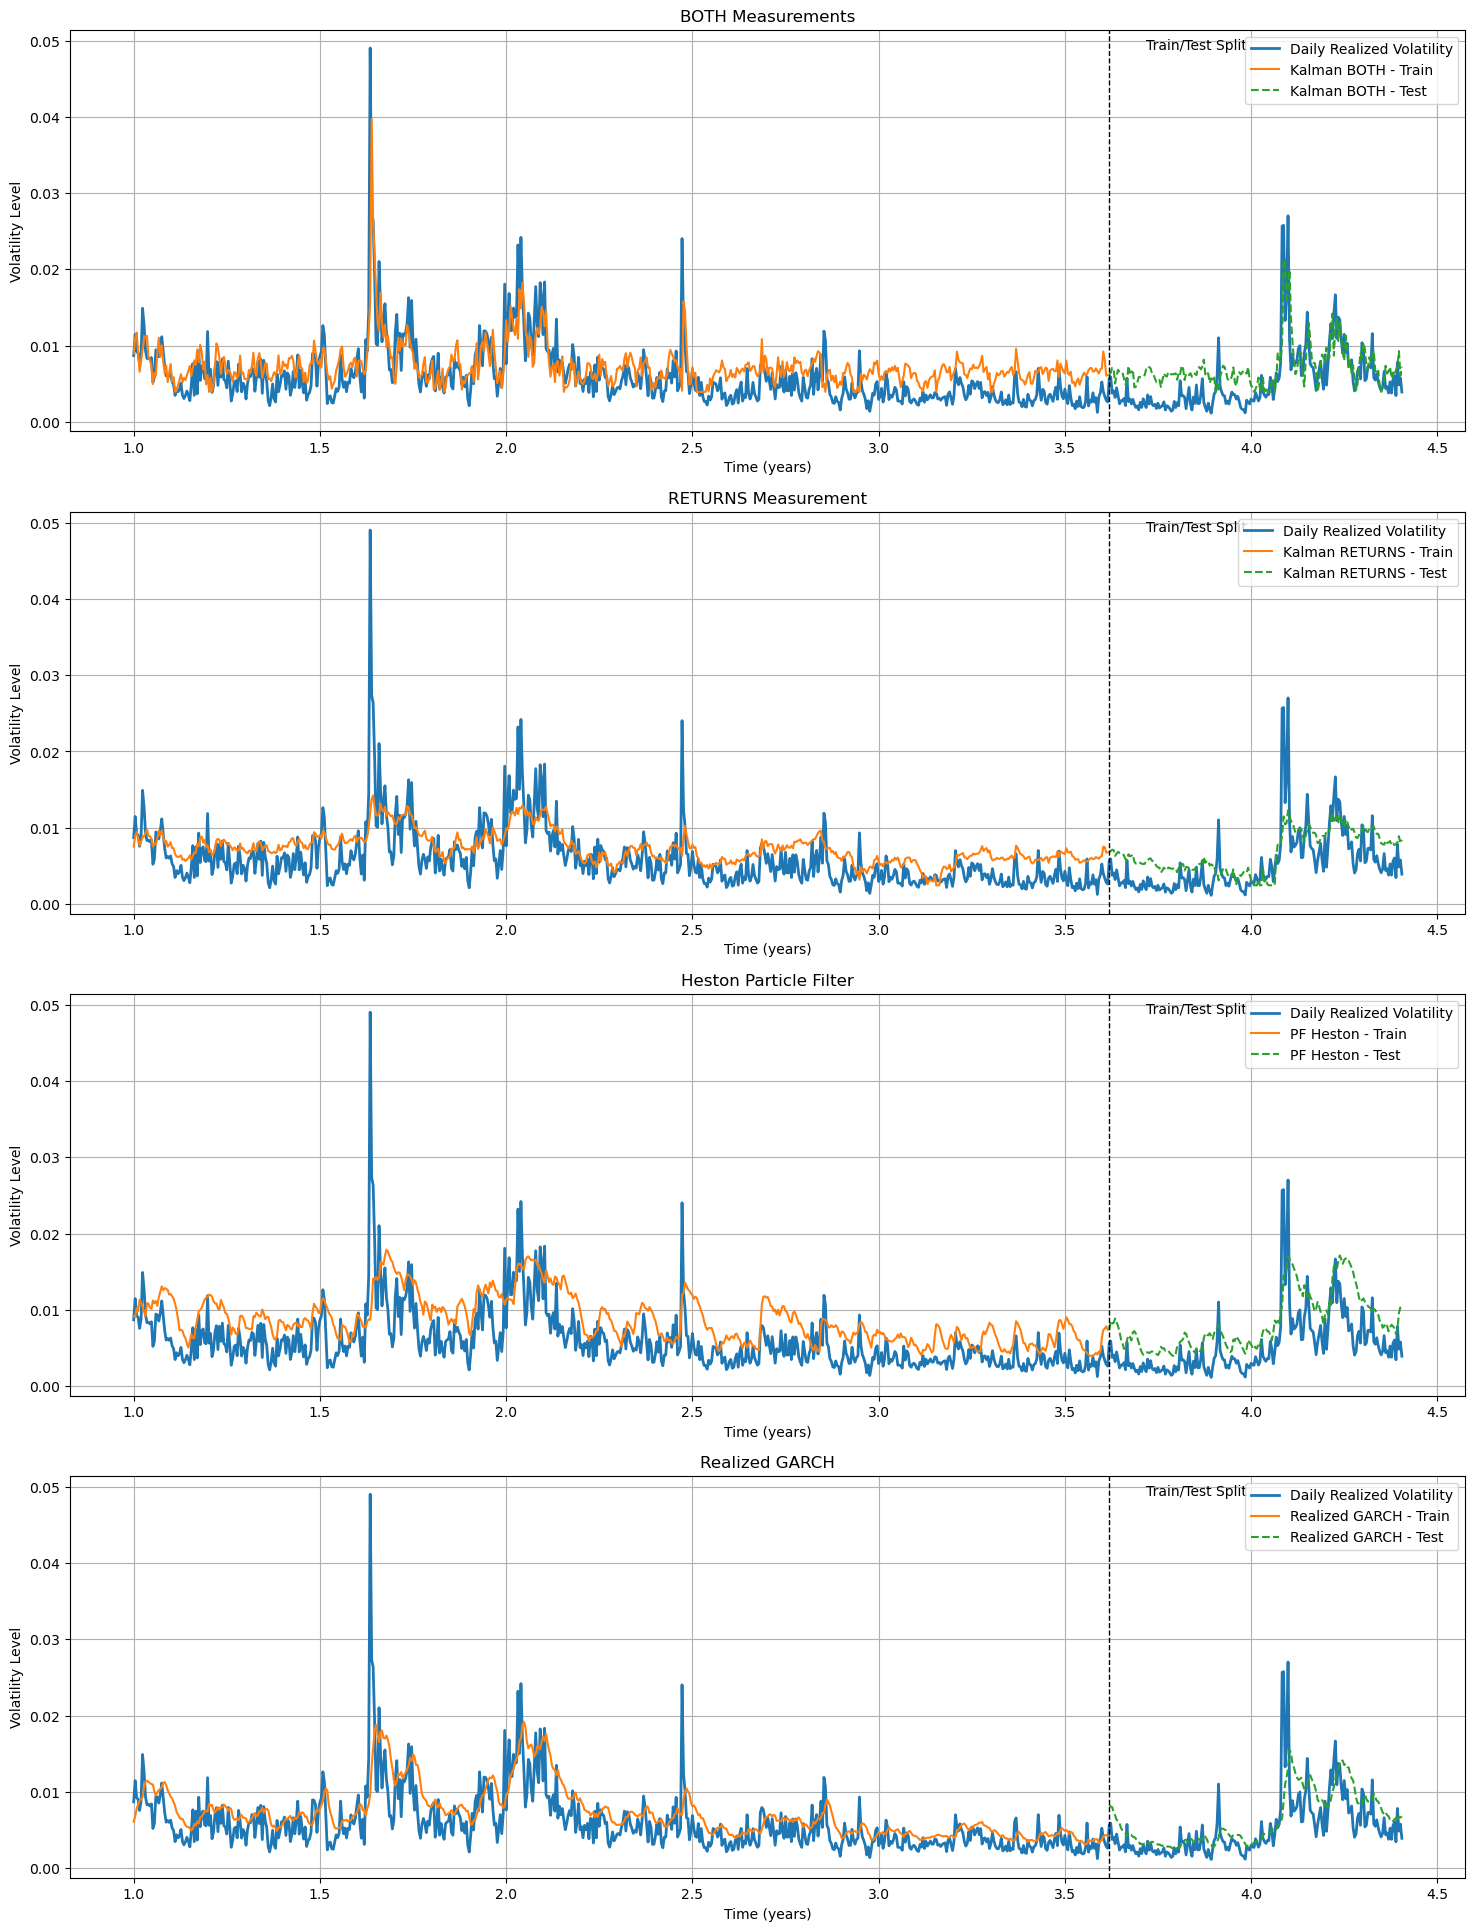

In [16]:
v_item = 'V_pred'

titles_all = ["BOTH Measurements", "RETURNS Measurement", "Heston Particle Filter", "Realized GARCH"]
labels_all = ["Kalman BOTH", "Kalman RETURNS", "PF Heston", "Realized GARCH"]
train_all = [train_result_both_corr[v_item].clip(1.55e-5, None), train_result_returns_corr[v_item].clip(6e-6, None), V_pf_train_daily, fitted_vol]
test_all = [test_result_both_corr[v_item].clip(1.55e-5, None), test_result_returns_corr[v_item].clip(6e-6, None), V_pf_test_daily, predicted_vol]

burnin = 252
time_daily = np.arange(len(daily_returns)) / 252
n_filters = len(train_all)
fig, axes = plt.subplots(n_filters, 1, figsize=(18, 6 * n_filters))

for i, ax in enumerate(axes):
    # Slice data
    filt_train = train_all[i][burnin:]
    true_train = daily_RV[burnin:split_index]
    filt_test = test_all[i]
    true_test = daily_RV[split_index:]

    # Sanity checks
    assert len(filt_train) == len(true_train), f"In-sample length mismatch for {titles_all[i]}"
    assert len(filt_test) == len(true_test), f"Out-of-sample length mismatch for {titles_all[i]}"

    # Plot true and predicted volatility
    ax.plot(time_daily[burnin:], np.sqrt(daily_RV[burnin:]), label="Daily Realized Volatility", lw=2)
    ax.plot(time_daily[burnin:split_index], np.sqrt(filt_train), label=f"{labels_all[i]} - Train", lw=1.5)
    ax.plot(time_daily[split_index:], np.sqrt(filt_test), label=f"{labels_all[i]} - Test", lw=1.5, linestyle="--")

    # Mark the train/test split
    ax.axvline(time_daily[split_index], color='black', linestyle='--', lw=1)
    ax.text(time_daily[split_index] + 0.1, ax.get_ylim()[1]*0.95, 'Train/Test Split', color='black')

    # === Add vertical lines for negative predicted variances ===
    # For train
    neg_train_indices = np.where(np.array(filt_train) < 0)[0]
    for idx in neg_train_indices:
        ax.axvline(time_daily[burnin + idx], color='red', linestyle=':', lw=1, alpha=0.7)

    # For test
    neg_test_indices = np.where(np.array(filt_test) < 0)[0]
    for idx in neg_test_indices:
        ax.axvline(time_daily[split_index + idx], color='red', linestyle=':', lw=1, alpha=0.7)

    # Final plot styling
    ax.set_title(f"{titles_all[i]}")
    ax.set_xlabel("Time (years)")
    ax.set_ylabel("Volatility Level")
    ax.legend(loc="upper right")
    ax.grid(True)

In [17]:
def qlike_loss(true_var, pred_var):
    y = np.asarray(true_var)
    h = np.asarray(pred_var)
    
    # eps = np.finfo(float).eps
    # ratio = y / (h + eps)
    ratio = y / h
    return np.mean(ratio - np.log(ratio) - 1)

model_names = ['RV-QLKF', 'QLKF', 'PF', 'Realized GARCH']
true_variances = daily_RV[split_index:]
true_volatilities = np.sqrt(true_variances)

rmse_scores  = {}
qlike_scores = {}

for name, pred_var in zip(model_names, np.array(test_all)):
    neg_mask = pred_var < 0
    pred_var[neg_mask] = true_variances[neg_mask]

    pred_vol = np.sqrt(pred_var)

    rmse_scores[name]  = np.sqrt(mean_squared_error(true_volatilities, pred_vol))
    qlike_scores[name] = qlike_loss(true_variances, pred_var)

print("Results:")
for name in model_names:
    print(f"{name:18s} RMSE: {rmse_scores[name]:.6f}, "
          f"QLIKE: {qlike_scores[name]:.6f}")

Results:
RV-QLKF            RMSE: 0.003355, QLIKE: 0.582537
QLKF               RMSE: 0.003297, QLIKE: 0.562725
PF                 RMSE: 0.004144, QLIKE: 0.592936
Realized GARCH     RMSE: 0.003289, QLIKE: 0.405672


In [18]:
# Apply the same preprocessing: fix negatives and compute loss matrices
corrected_preds = []
mse_matrix = []
qlike_matrix = []

def qlike(true_var, pred_var):
    y = np.asarray(true_var)
    h = np.asarray(pred_var)
    
    eps = np.finfo(float).eps
    ratio = y / (h + eps)
    return ratio - np.log(ratio) - 1

for forecast in test_all:
    pred_var = np.array(forecast)

    # Fix negative variances
    neg_mask = pred_var < 0
    pred_var[neg_mask] = true_variances[neg_mask]

    # Compute predicted vol
    pred_vol = np.sqrt(pred_var)

    # Store for matrix stacking
    mse_matrix.append((true_volatilities - pred_vol)**2)
    qlike_matrix.append(qlike(true_variances, pred_var))

# Stack as columns: shape (T, num_models)
mse_matrix = np.column_stack(mse_matrix)
qlike_matrix = np.column_stack(qlike_matrix)

# Initialize and compute Model Confidence Set (MCS)
from model_confidence_set import ModelConfidenceSet

mcs_mse_90 = ModelConfidenceSet(mse_matrix, n_boot=10000, alpha=0.10, show_progress=True)
mcs_qlike_90 = ModelConfidenceSet(qlike_matrix, n_boot=10000, alpha=0.10, show_progress=True)

mcs_mse_75 = ModelConfidenceSet(mse_matrix, n_boot=10000, alpha=0.25, show_progress=True)
mcs_qlike_75 = ModelConfidenceSet(qlike_matrix, n_boot=10000, alpha=0.25, show_progress=True)

mcs_mse_90.compute()
mcs_qlike_90.compute()

mcs_mse_75.compute()
mcs_qlike_75.compute()

mcs_mse_results_90 = mcs_mse_90.results()
mcs_qlike_results_90 = mcs_qlike_90.results()

mcs_mse_results_75 = mcs_mse_75.results()
mcs_qlike_results_75 = mcs_qlike_75.results()

Computing MCS: 100%|██████████| 3/3 [00:00<00:00, 539.16model/s]


In [19]:
mcs_mse_results_90

,pvalues,status
models,,
3,0.0562,excluded
1,0.9704,included
2,0.9778,included
4,1.0000,included


In [20]:
mcs_qlike_results_90

,pvalues,status
models,,
3,0.1238,included
2,0.1256,included
1,0.1805,included
4,1.0000,included


In [21]:
mcs_mse_results_75

,pvalues,status
models,,
3,0.0523,excluded
1,0.9708,included
2,0.9786,included
4,1.0000,included


In [22]:
mcs_qlike_results_75

,pvalues,status
models,,
3,0.1326,excluded
2,0.1326,excluded
1,0.1758,excluded
4,1.0000,included


# Distribution of returns

In [26]:
df['return']

Time
2014-01-02         NaN
2014-01-03   -0.000344
2014-01-06   -0.002646
2014-01-07    0.006113
2014-01-08   -0.000278
                ...   
2018-05-24   -0.002390
2018-05-28   -0.011562
2018-05-29    0.012634
2018-05-30   -0.006922
2018-05-31    0.010677
Name: return, Length: 1112, dtype: float64

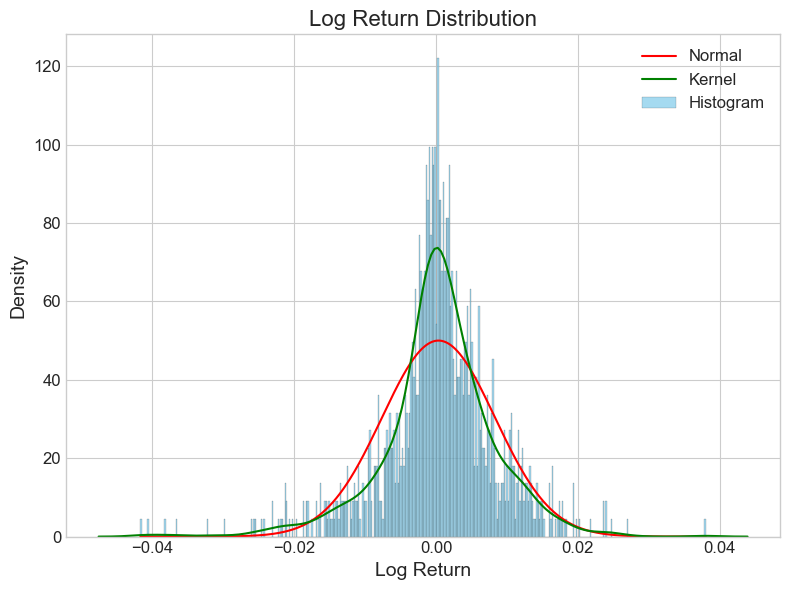

In [27]:
# Prepare data
log_ret = df['return'].dropna()

# Plot
plt.figure(figsize=(8, 6))
sns.histplot(log_ret, kde=False, stat='density', bins=400, color='skyblue', label='Histogram')

# Normal fit
mu, std = norm.fit(log_ret)
x_vals = np.linspace(log_ret.min(), log_ret.max(), 500)
plt.plot(x_vals, norm.pdf(x_vals, mu, std), 'r', label='Normal')

# Kernel Density Estimate
sns.kdeplot(log_ret, color='green', label='Kernel')

# Labels and formatting
plt.title('Log Return Distribution', fontsize=16)
plt.xlabel('Log Return', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.tick_params(axis='both', labelsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Distribution of RV

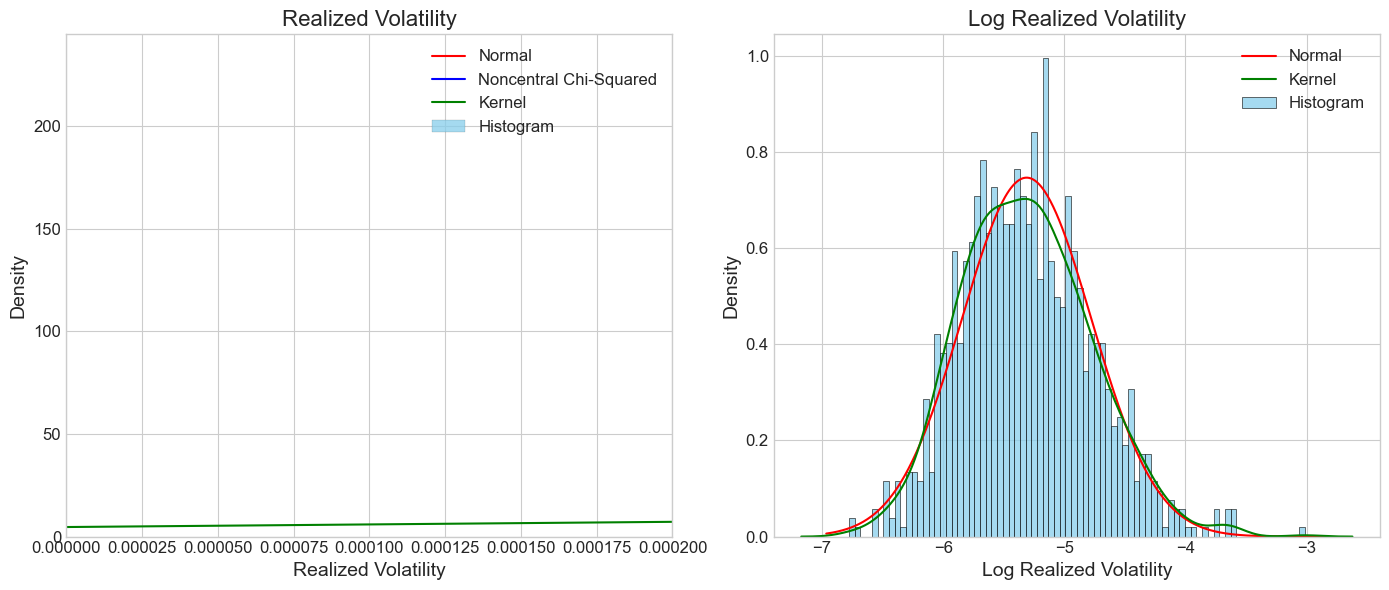

In [28]:
# Prepare data
rv = np.sqrt(df['rv10']).dropna()
log_rv = np.log(rv)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Left subplot: Realized volatility histogram and density curves
sns.histplot(rv, kde=False, stat='density', bins=400, color='skyblue', ax=ax[0], label='Histogram')

xmin, xmax = rv.min(), rv.max()
x_vals = np.linspace(xmin, xmax, 500)

# Fit and plot the log normal distribution
# shape_logn, loc_logn, scale_logn = lognorm.fit(rv, floc=0)  # Usually loc is set to 0
# ax[0].plot(x_vals, lognorm.pdf(x_vals, shape_logn, loc=loc_logn, scale=scale_logn), 'r', label='Lognormal')

mu, std = norm.fit(rv)
ax[0].plot(x_vals, norm.pdf(x_vals, mu, std), 'r', label='Normal')

# Fit the noncentral chi-squared distribution with loc fixed at 0
df_ncx2, nc_val, loc_val, scale_val = ncx2.fit(rv, floc=0)
ax[0].plot(x_vals, ncx2.pdf(x_vals, df_ncx2, nc_val, loc=loc_val, scale=scale_val), 'b', label='Noncentral Chi-Squared')

# Add kernel density estimate
sns.kdeplot(rv, ax=ax[0], color='green', label='Kernel')

ax[0].set_title('Realized Volatility', fontsize=16)
ax[0].set_xlabel('Realized Volatility', fontsize=14)
ax[0].set_ylabel('Density', fontsize=14)
ax[0].set_xlim(0, 0.0002)
ax[0].tick_params(axis='both', labelsize=12)
ax[0].legend(fontsize=12)

# Right subplot: Log realized volatility histogram and normal density
sns.histplot(log_rv, kde=False, stat='density', bins=80, color='skyblue', ax=ax[1], label='Histogram')
xmin_log, xmax_log = ax[1].get_xlim()
x_vals_log = np.linspace(xmin_log, xmax_log, 500)
mu_log, std_log = norm.fit(log_rv)
ax[1].plot(x_vals_log, norm.pdf(x_vals_log, mu_log, std_log), 'r', label='Normal')
sns.kdeplot(log_rv, ax=ax[1], color='green', label='Kernel')

ax[1].set_title('Log Realized Volatility', fontsize=16)
ax[1].set_xlabel('Log Realized Volatility', fontsize=14)
ax[1].set_ylabel('Density', fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)
ax[1].legend(fontsize=12)

plt.tight_layout()
plt.show()


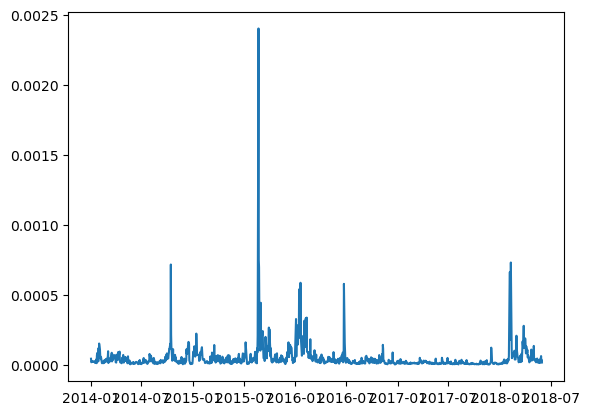

In [17]:
plt.plot(rv)

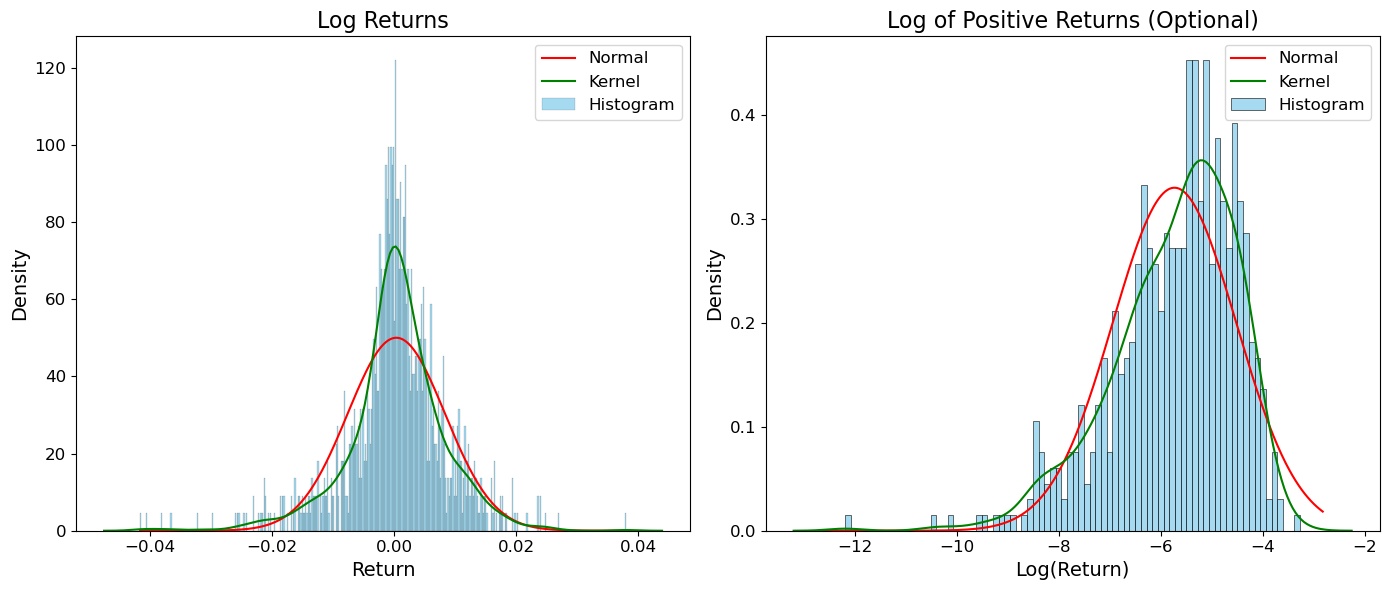

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# Prepare data
rtn = np.log(df['close_price']).diff().dropna()
log_rtn = np.log(rtn[rtn > 0])  # optional, if you want to still look at log of positive returns

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Left subplot: Return histogram and density curves
sns.histplot(rtn, kde=False, stat='density', bins=400, color='skyblue', ax=ax[0], label='Histogram')

xmin, xmax = rtn.min(), rtn.max()
x_vals = np.linspace(xmin, xmax, 500)

# Fit and plot the normal distribution
mu_rtn, std_rtn = norm.fit(rtn)
ax[0].plot(x_vals, norm.pdf(x_vals, mu_rtn, std_rtn), 'r', label='Normal')

# Add kernel density estimate
sns.kdeplot(rtn, ax=ax[0], color='green', label='Kernel')

ax[0].set_title('Log Returns', fontsize=16)
ax[0].set_xlabel('Return', fontsize=14)
ax[0].set_ylabel('Density', fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)
ax[0].legend(fontsize=12)

# Right subplot: Log of positive returns (optional, for exploration)
sns.histplot(log_rtn, kde=False, stat='density', bins=80, color='skyblue', ax=ax[1], label='Histogram')
xmin_log, xmax_log = ax[1].get_xlim()
x_vals_log = np.linspace(xmin_log, xmax_log, 500)
mu_log, std_log = norm.fit(log_rtn)
ax[1].plot(x_vals_log, norm.pdf(x_vals_log, mu_log, std_log), 'r', label='Normal')
sns.kdeplot(log_rtn, ax=ax[1], color='green', label='Kernel')

ax[1].set_title('Log of Positive Returns (Optional)', fontsize=16)
ax[1].set_xlabel('Log(Return)', fontsize=14)
ax[1].set_ylabel('Density', fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)
ax[1].legend(fontsize=12)

plt.tight_layout()
plt.show()


# Autocorrelation

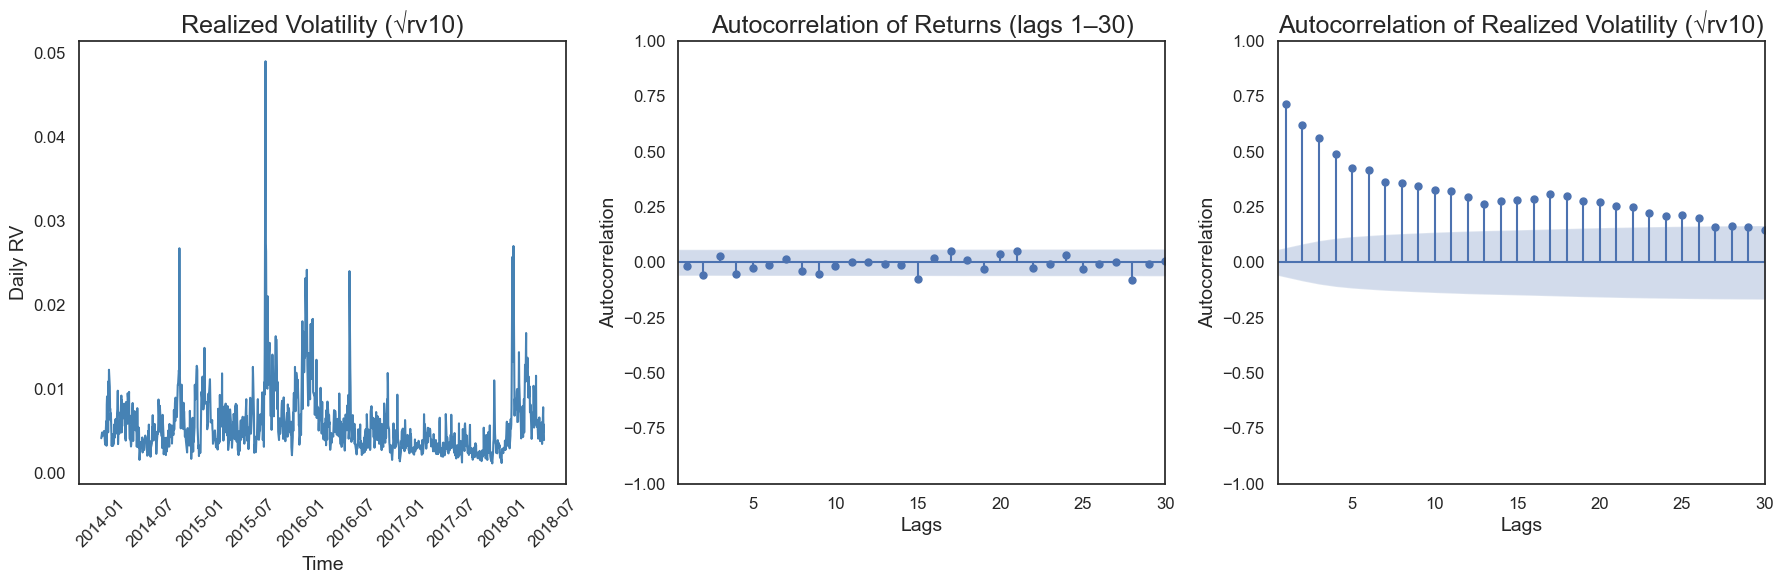

In [19]:
returns = np.log(df['close_price']).diff().iloc[1:]
rv10 = df['rv10'].iloc[1:]
realized_vol = np.sqrt(rv10)

sns.set(style='white')

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. Volatility plot 
sns.lineplot(x=realized_vol.index, y=realized_vol.values, ax=axes[0], color='steelblue')
axes[0].set_title('Realized Volatility (√rv10)', fontsize=18)
axes[0].set_xlabel('Time', fontsize=14)
axes[0].set_ylabel('Daily RV', fontsize=14)
axes[0].tick_params(axis='both', labelsize=12)
axes[0].tick_params(axis='x', rotation=45)  # Rotate x-axis ticks

# 2. Autocorrelation of returns
plot_acf(returns, lags=30, ax=axes[1])
axes[1].set_title('Autocorrelation of Returns (lags 1–30)', fontsize=18)
axes[1].set_xlabel('Lags', fontsize=14)
axes[1].set_ylabel('Autocorrelation', fontsize=14)
axes[1].tick_params(axis='both', labelsize=12)
axes[1].set_xlim(0.5, 30)

# 3. Autocorrelation of realized volatility
plot_acf(realized_vol, lags=30, ax=axes[2])
axes[2].set_title('Autocorrelation of Realized Volatility (√rv10)', fontsize=18)
axes[2].set_xlabel('Lags', fontsize=14)
axes[2].set_ylabel('Autocorrelation', fontsize=14)
axes[2].tick_params(axis='both', labelsize=12)
axes[2].set_xlim(0.5, 30)

plt.tight_layout()
plt.show()